<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/ProduzGraficos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import json
import sklearn
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from itertools import cycle

import regex as re

# Carrega arquivo de saída (resultados)

In [41]:
# Caminho arquivo de saída
PATH_ARQ_SAIDA = "/content/drive/MyDrive/TCC/resultados/resultados.csv"

# CORES = list(matplotlib.colors.get_named_colors_mapping().keys())

resultados = pd.read_csv(PATH_ARQ_SAIDA, index_col=0)
resultados.head()

,rede,base,funcao_ativacao,otimizador,acuracia,roc_curve,train_resume,confusion_matrix
0,CNN,BASE 2,SIGMOID,1,0.919622,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 954, ""01"": 93, ""10"": 77, ""11"": 991}"
1,CNN,BASE 2,SIGMOID,1,0.925768,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 983, ""01"": 64, ""10"": 93, ""11"": 975}"


In [50]:
list(matplotlib.colors.get_named_colors_mapping().keys())

['xkcd:cloudy blue',
 'xkcd:dark pastel green',
 'xkcd:dust',
 'xkcd:electric lime',
 'xkcd:fresh green',
 'xkcd:light eggplant',
 'xkcd:nasty green',
 'xkcd:really light blue',
 'xkcd:tea',
 'xkcd:warm purple',
 'xkcd:yellowish tan',
 'xkcd:cement',
 'xkcd:dark grass green',
 'xkcd:dusty teal',
 'xkcd:grey teal',
 'xkcd:macaroni and cheese',
 'xkcd:pinkish tan',
 'xkcd:spruce',
 'xkcd:strong blue',
 'xkcd:toxic green',
 'xkcd:windows blue',
 'xkcd:blue blue',
 'xkcd:blue with a hint of purple',
 'xkcd:booger',
 'xkcd:bright sea green',
 'xkcd:dark green blue',
 'xkcd:deep turquoise',
 'xkcd:green teal',
 'xkcd:strong pink',
 'xkcd:bland',
 'xkcd:deep aqua',
 'xkcd:lavender pink',
 'xkcd:light moss green',
 'xkcd:light seafoam green',
 'xkcd:olive yellow',
 'xkcd:pig pink',
 'xkcd:deep lilac',
 'xkcd:desert',
 'xkcd:dusty lavender',
 'xkcd:purpley grey',
 'xkcd:purply',
 'xkcd:candy pink',
 'xkcd:light pastel green',
 'xkcd:boring green',
 'xkcd:kiwi green',
 'xkcd:light grey green',
 

In [67]:
# Plot de Gráficos

def plot_accuracy(history, rede, base):
    _,accuracy,loss,val_accuracy,val_loss = list(history.keys())
    acc = list(history[accuracy].values())
    test_acc = list(history[val_accuracy].values())
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, test_acc)
    plt.legend(['train', 'test'], loc='upper left')
    plt.title('Gráfico da acurácia para '+ rede + ' com a base '+ base + '.') 
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

def plot_loss(history, rede, base):
    _,accuracy,loss,val_accuracy,val_loss = list(history.keys())
    loss = list(history[loss].values())
    val_loss = list(history[val_loss].values())
    epochs = range(len(loss))
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.legend(['train', 'test'], loc="lower left")
    plt.title('Gráfico da perda para '+ rede + ' com a base '+ base + '.') 
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def plot_roc_curve(roc_curves):        
    plt.figure()
    colors = cycle(["red","blue","darkorange","aqua","magenta","lime","eggplant","cornflowerblue","yellowishtan"])
    for roc_curve, color in zip(roc_curves, colors):
      false_positive_rate, true_positive_rate, score = list(roc_curve[0].keys())
      false_positive_rate = roc_curve[0][false_positive_rate]
      true_positive_rate = roc_curve[0][true_positive_rate]
      score = roc_curve[0][score]
      plt.plot(false_positive_rate, true_positive_rate, color=color, label="{0} (area = {1:0.2f})".format(roc_curve[1], score))
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('Gráfico da curva ROC de todos as redes pesquisadas.')
    plt.legend(loc="lower right")
    plt.show()
    
    # zoom
    # plt.xlim([0.0, 0.2])
    # plt.ylim([0.8, 1.05])
  

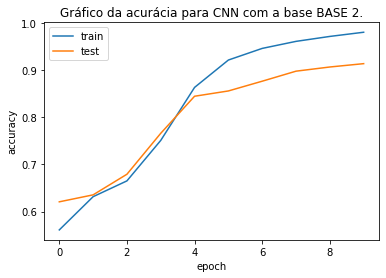

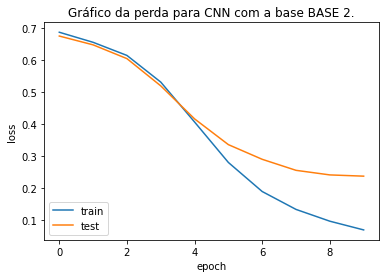

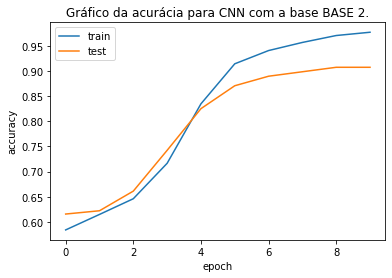

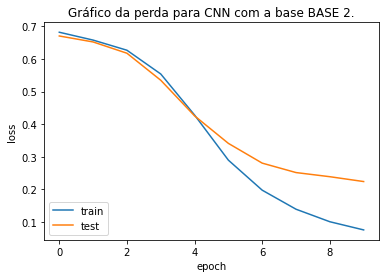

In [68]:
for train_resume, rede, base in zip(resultados.train_resume, resultados.rede, resultados.base):
  plot_accuracy(json.loads(train_resume), rede, base)
  plot_loss(json.loads(train_resume), rede, base)

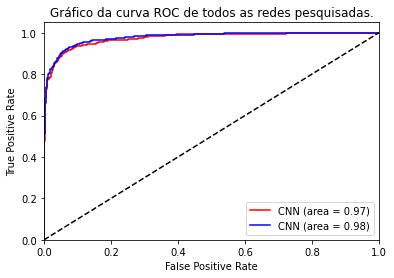

In [69]:
roc_curve_list = []
for roc_curve, rede in zip(resultados.roc_curve, resultados.rede):
  roc_curve = json.loads(roc_curve)
  roc_curve_list.append([roc_curve, rede])

plot_roc_curve(roc_curve_list)

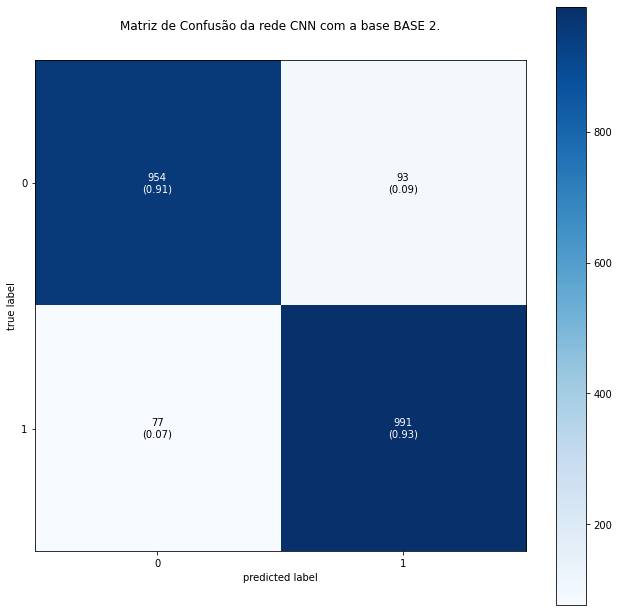

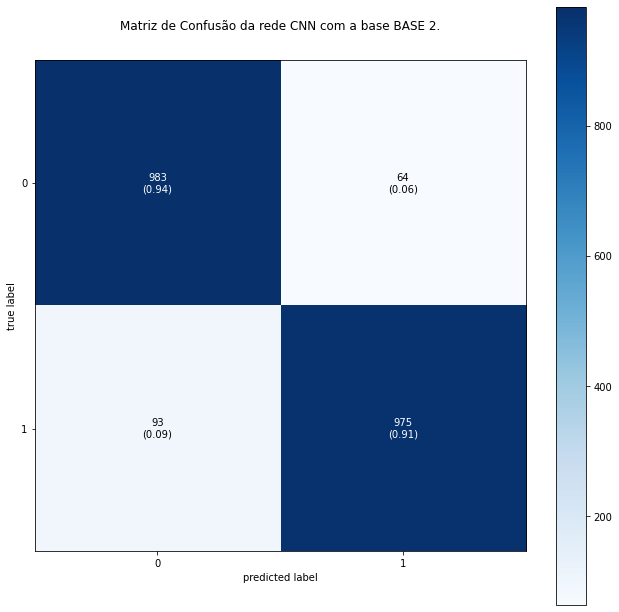

In [70]:
for confusion_matrix, rede, base in zip(resultados.confusion_matrix, resultados.rede, resultados.base):
  confusion_matrix = json.loads(confusion_matrix)
  confusion_matrix = np.array([ [confusion_matrix["00"],confusion_matrix["01"]],
                                [confusion_matrix["10"],confusion_matrix["11"]] ])

  fig,ax = plot_confusion_matrix(figsize=(11, 11),
                                  conf_mat=confusion_matrix,
                                  colorbar=True,
                                  show_absolute=True,
                                  show_normed=True,
                                )
  plt.title('Matriz de Confusão da rede '+ rede + ' com a base '+ base + '.') 
  plt.show()